In [626]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
import numpy as np
import math

In [627]:
ELEMENT_SIZE=ARRAY_SIZE=8

In [628]:

array=np.random.randint(ELEMENT_SIZE, size=ARRAY_SIZE)
# array=[1,2,3,4,3,5,7]

In [629]:
# shuffle the array 
# np.random.shuffle(array)
# array = np.array([5, 7, 2, 2, 1, 3, 9, 9, 0, 7])
array

array([7, 3, 1, 4, 6, 7, 6, 3])

In [630]:
RootN=math.ceil(np.sqrt(ARRAY_SIZE))
# choose first rootN elements
marked = array[:int(RootN)]
marked

array([7, 3, 1])

In [631]:
if(len(set(marked))!=len(marked)):
    print("Error: Marked elements are not unique, found duplicates")

In [632]:
remaining = array[int(RootN):]
remaining



array([4, 6, 7, 6, 3])

In [633]:
# remaining=[1,2,3,4]
# solution_idx=[2]
T=len(remaining)
# log of T
idx_qubits=math.ceil(np.log2(T))
element_qubits=math.ceil(np.log2(ELEMENT_SIZE))
oracle_qubits=element_qubits
qubits=idx_qubits+oracle_qubits
print(idx_qubits,element_qubits,oracle_qubits,qubits)


3 3 3 6


In [634]:
def grover_iterator(oracle_circuit,idx_qubits,qubits):
    qc=QuantumCircuit(qubits)
    qc.append(oracle_circuit,range(qubits))
    # qc.barrier()
    qc.h(range(idx_qubits))
    qc.h(qubits-1)
    qc.x(range(idx_qubits))
    qc.x(qubits-1)
    qc.barrier()
    qc.h(qubits-1)
    qc.mcx(list(range(idx_qubits)),qubits-1)
    qc.h(qubits-1)
    qc.barrier()
    qc.x(qubits-1)
    qc.x(range(idx_qubits))
    qc.h(qubits-1)
    qc.h(range(idx_qubits))
    qc.barrier()
    return qc



In [635]:
def A(idx_qubits,qubits):
    qc = QuantumCircuit(qubits)
    for qubit in range(idx_qubits):
        qc.h(qubit)
    qc.h(qubits-1)
    qc.barrier()
    return qc

In [636]:
def Array_oracle(idx_qubits,oracle_qubits,Array):
    oracle = QuantumCircuit(idx_qubits+oracle_qubits)
    array_len = len(Array)
    idx=[i for i in range(2**idx_qubits)]
    oracle.barrier()
    for element in idx:
        # Convert idx to binary representation
        binary_rep_idx = bin(element)[2:].zfill(idx_qubits)
        # print(binary_rep_idx)

        # reverse the binary representation
        binary_rep_idx = binary_rep_idx[::-1]

        # Apply X gates on qubits where binary_rep is '1'
        for i, bit in enumerate(binary_rep_idx):
            if bit == '0':
                oracle.x(i)

        # Apply multi-controlled X gate to create elements of array
        if(element>=array_len):
            number=0
        else:
            number=Array[element]
        binary_rep_number = bin(number)[2:].zfill(oracle_qubits)
        binary_rep_number = binary_rep_number[::-1]
        # print(binary_rep_number,number,binary_rep_idx,element)
        # print(binary_rep_number)
        for i, bit in enumerate(binary_rep_number):
            if bit == '1':
                oracle.mcx(list(range(0,idx_qubits)), idx_qubits+i)
        # oracle.mcx(list(range(0,idx_qubits)), idx_qubits+1)


        # Unapply X gates
        for i, bit in enumerate(binary_rep_idx):
            if bit == '0':
                oracle.x(i)
        
        oracle.barrier()

    oracle.barrier()
    print("Array Oracle circuit:")
    print(oracle)
    return oracle



# print("idx_qubits",idx_qubits)
print(remaining)
array_circuit=Array_oracle(idx_qubits,oracle_qubits,remaining)


[4 6 7 6 3]
Array Oracle circuit:
      ░ ┌───┐     ┌───┐ ░                      ░ ┌───┐               ┌───┐ ░ »
q_0: ─░─┤ X ├──■──┤ X ├─░────────■────■────────░─┤ X ├──■────■────■──┤ X ├─░─»
      ░ ├───┤  │  ├───┤ ░ ┌───┐  │    │  ┌───┐ ░ └───┘  │    │    │  └───┘ ░ »
q_1: ─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░────────■────■────■────────░─»
      ░ ├───┤  │  ├───┤ ░ ├───┤  │    │  ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ »
q_2: ─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─»
      ░ └───┘  │  └───┘ ░ └───┘  │    │  └───┘ ░ └───┘┌─┴─┐  │    │  └───┘ ░ »
q_3: ─░────────┼────────░────────┼────┼────────░──────┤ X ├──┼────┼────────░─»
      ░        │        ░      ┌─┴─┐  │        ░      └───┘┌─┴─┐  │        ░ »
q_4: ─░────────┼────────░──────┤ X ├──┼────────░───────────┤ X ├──┼────────░─»
      ░      ┌─┴─┐      ░      └───┘┌─┴─┐      ░           └───┘┌─┴─┐      ░ »
q_5: ─░──────┤ X ├──────░───────────┤ X ├──────░────────────────┤ X ├──────░─»
      ░      └───┘

In [637]:
# Create oracle for the Grover's algorithm
def comparision_oracle(idx_qubits, oracale_qubits,marked_elements):
    oracle = QuantumCircuit(idx_qubits+oracale_qubits)

    oracle.barrier()
    for element in marked_elements:
        # Convert idx to binary representation
        binary_rep = bin(element)[2:].zfill(oracale_qubits-1)
        
        # print(binary_rep)
        # reverse the binary representation
        binary_rep = binary_rep[::-1]
        # Apply X gates on qubits where binary_rep is '1'
        for i, bit in enumerate(binary_rep):
            if bit == '0':
                oracle.x(i+idx_qubits)

        # Apply multi-controlled X gate
        oracle.h(oracale_qubits-1+idx_qubits)
        oracle.mcx(list(range(0+idx_qubits,oracale_qubits-1+idx_qubits)), oracale_qubits-1+idx_qubits)
        oracle.h(oracale_qubits-1+idx_qubits)
        # Unapply X gates
        for i, bit in enumerate(binary_rep):
            if bit == '0':
                oracle.x(i+idx_qubits)
        
        oracle.barrier()

    oracle.barrier()
    print("Compasion Oracle circuit:")
    print(oracle)
    return oracle

print(marked)
comparision_oracle_circuit = comparision_oracle(idx_qubits,oracle_qubits,marked_elements=marked)


[7 3 1]
Compasion Oracle circuit:
      ░                 ░                 ░                 ░  ░ 
q_0: ─░─────────────────░─────────────────░─────────────────░──░─
      ░                 ░                 ░                 ░  ░ 
q_1: ─░─────────────────░─────────────────░─────────────────░──░─
      ░                 ░                 ░                 ░  ░ 
q_2: ─░─────────────────░─────────────────░─────────────────░──░─
      ░                 ░                 ░                 ░  ░ 
q_3: ─░────────■────────░────────■────────░────────■────────░──░─
      ░        │        ░        │        ░ ┌───┐  │  ┌───┐ ░  ░ 
q_4: ─░────────■────────░────────■────────░─┤ X ├──■──┤ X ├─░──░─
      ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░  ░ 
q_5: ─░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░──░─
      ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░  ░ 


In [638]:
oracle_circuit=QuantumCircuit(qubits)
oracle_circuit.append(array_circuit,range(qubits))    
oracle_circuit.append(comparision_oracle_circuit,range(qubits))
oracle_circuit.append(array_circuit,range(qubits))
# oracle_circuit.extend(comparision_oracle_circuit)
oracle_circuit.decompose().draw()

░ ┌───┐     ┌───┐ ░                      ░ ┌───┐               ┌───┐ ░ »
q_0: ─░─┤ X ├──■──┤ X ├─░────────■────■────────░─┤ X ├──■────■────■──┤ X ├─░─»
      ░ ├───┤  │  ├───┤ ░ ┌───┐  │    │  ┌───┐ ░ └───┘  │    │    │  └───┘ ░ »
q_1: ─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░────────■────■────■────────░─»
      ░ ├───┤  │  ├───┤ ░ ├───┤  │    │  ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ »
q_2: ─░─┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─»
      ░ └───┘  │  └───┘ ░ └───┘  │    │  └───┘ ░ └───┘┌─┴─┐  │    │  └───┘ ░ »
q_3: ─░────────┼────────░────────┼────┼────────░──────┤ X ├──┼────┼────────░─»
      ░        │        ░      ┌─┴─┐  │        ░      └───┘┌─┴─┐  │        ░ »
q_4: ─░────────┼────────░──────┤ X ├──┼────────░───────────┤ X ├──┼────────░─»
      ░      ┌─┴─┐      ░      └───┘┌─┴─┐      ░           └───┘┌─┴─┐      ░ »
q_5: ─░──────┤ X ├──────░───────────┤ X ├──────░────────────────┤ X ├──────░─»
      ░      └───┘      ░           └───┘      ░                └───┘      ░ »
«                          ░ ┌───┐          ┌───┐ ░            ░ ┌───┐┌───┐ ░ »
«q_0: ───────■────■────────░─┤ X ├──■────■──┤ X ├─░────────────░─┤ X ├┤ X ├─░─»
«            │    │        ░ ├───┤  │    │  ├───┤ ░ ┌───┐┌───┐ ░ └───┘└───┘ ░ »
«q_1: ───────■────■────────░─┤ X ├──■────■──┤ X ├─░─┤ X ├┤ X ├─░────────────░─»
«     ┌───┐  │    │  ┌───┐ ░ └───┘  │    │  └───┘ ░ └───┘└───┘ ░            ░ »
«q_2: ┤ X ├──■────■──┤ X ├─░────────■────■────────░────────────░────────────░─»
«     └───┘  │    │  └───┘ ░      ┌─┴─┐  │        ░            ░            ░ »
«q_3: ───────┼────┼────────░──────┤ X ├──┼────────░────────────░────────────░─»
«          ┌─┴─┐  │        ░      └───┘┌─┴─┐      ░            ░            ░ »
«q_4: ─────┤ X ├──┼────────░───────────┤ X ├──────░────────────░────────────░─»
«          └───┘┌─┴─┐      ░           └───┘      ░            ░            ░ »
«q_5: ──────────┤ X ├──────░──────────────────────░────────────░────────────░─»
«               └───┘      ░                      ░            ░            ░ »
«      ░  ░  ░                 ░                 ░                 ░  ░  ░ »
«q_0: ─░──░──░─────────────────░─────────────────░─────────────────░──░──░─»
«      ░  ░  ░                 ░                 ░                 ░  ░  ░ »
«q_1: ─░──░──░─────────────────░─────────────────░─────────────────░──░──░─»
«      ░  ░  ░                 ░                 ░                 ░  ░  ░ »
«q_2: ─░──░──░─────────────────░─────────────────░─────────────────░──░──░─»
«      ░  ░  ░                 ░                 ░                 ░  ░  ░ »
«q_3: ─░──░──░────────■────────░────────■────────░────────■────────░──░──░─»
«      ░  ░  ░        │        ░        │        ░ ┌───┐  │  ┌───┐ ░  ░  ░ »
«q_4: ─░──░──░────────■────────░────────■────────░─┤ X ├──■──┤ X ├─░──░──░─»
«      ░  ░  ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤┌─┴─┐├───┤ ░  ░  ░ »
«q_5: ─░──░──░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├─░──░──░─»
«      ░  ░  ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░  ░  ░ »
«     ┌───┐     ┌───┐ ░                      ░ ┌───┐               ┌───┐ ░ »
«q_0: ┤ X ├──■──┤ X ├─░────────■────■────────░─┤ X ├──■────■────■──┤ X ├─░─»
«     ├───┤  │  ├───┤ ░ ┌───┐  │    │  ┌───┐ ░ └───┘  │    │    │  └───┘ ░ »
«q_1: ┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░────────■────■────■────────░─»
«     ├───┤  │  ├───┤ ░ ├───┤  │    │  ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ »
«q_2: ┤ X ├──■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░─┤ X ├──■────■────■──┤ X ├─░─»
«     └───┘  │  └───┘ ░ └───┘  │    │  └───┘ ░ └───┘┌─┴─┐  │    │  └───┘ ░ »
«q_3: ───────┼────────░────────┼────┼────────░──────┤ X ├──┼────┼────────░─»
«            │        ░      ┌─┴─┐  │        ░      └───┘┌─┴─┐  │        ░ »
«q_4: ───────┼────────░──────┤ X ├──┼────────░───────────┤ X ├──┼────────░─»
«          ┌─┴─┐      ░      └───┘┌─┴─┐      ░           └───┘┌─┴─┐      ░ »
«q_5: ─────┤ X ├──────░───────────┤ X ├──────░────────────────┤ X ├──────░─»
«          └──

In [639]:
grover=grover_iterator(oracle_circuit,idx_qubits,qubits)



In [640]:
grover.decompose().draw()

┌───────────────┐┌───────────────┐┌───────────────┐┌─────────┐»
q_0: ┤0              ├┤0              ├┤0              ├┤ U2(0,π) ├»
     │               ││               ││               │├─────────┤»
q_1: ┤1              ├┤1              ├┤1              ├┤ U2(0,π) ├»
     │               ││               ││               │├─────────┤»
q_2: ┤2              ├┤2              ├┤2              ├┤ U2(0,π) ├»
     │  circuit-1024 ││  circuit-1025 ││  circuit-1024 │└─────────┘»
q_3: ┤3              ├┤3              ├┤3              ├───────────»
     │               ││               ││               │           »
q_4: ┤4              ├┤4              ├┤4              ├───────────»
     │               ││               ││               │┌─────────┐»
q_5: ┤5              ├┤5              ├┤5              ├┤ U2(0,π) ├»
     └───────────────┘└───────────────┘└───────────────┘└─────────┘»
«     ┌───────────┐ ░  ┌────────┐                                          »
«q_0: ┤ U3(π,0,π) ├─░──┤ P(π/8) ├──■───────────────■────────────────────■──»
«     ├───────────┤ ░  ├────────┤┌─┴─┐┌─────────┐┌─┴─┐                  │  »
«q_1: ┤ U3(π,0,π) ├─░──┤ P(π/8) ├┤ X ├┤ P(-π/8) ├┤ X ├──■───────────────┼──»
«     ├───────────┤ ░  ├────────┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐»
«q_2: ┤ U3(π,0,π) ├─░──┤ P(π/8) ├─────────────────────┤ X ├┤ P(-π/8) ├┤ X ├»
«     └───────────┘ ░  └────────┘                     └───┘└─────────┘└───┘»
«q_3: ──────────────░──────────────────────────────────────────────────────»
«                   ░                                                      »
«q_4: ──────────────░──────────────────────────────────────────────────────»
«     ┌───────────┐ ░ ┌─────────┐┌───┐ ┌────────┐                          »
«q_5: ┤ U3(π,0,π) ├─░─┤ U2(0,π) ├┤ H ├─┤ P(π/8) ├──────────────────────────»
«     └───────────┘ ░ └─────────┘└───┘ └────────┘                          »
«                                                                        »
«q_0: ────────────────────────────■──────────────────────────────────────»
«                                 │                                      »
«q_1: ────────────■───────────────┼────────────────────■─────────────────»
«     ┌────────┐┌─┴─┐┌─────────┐┌─┴─┐                  │                 »
«q_2: ┤ P(π/8) ├┤ X ├┤ P(-π/8) ├┤ X ├──■───────────────┼──────────────■──»
«     └────────┘└───┘└─────────┘└───┘  │               │              │  »
«q_3: ─────────────────────────────────┼───────────────┼──────────────┼──»
«                                      │               │              │  »
«q_4: ─────────────────────────────────┼───────────────┼──────────────┼──»
«                                    ┌─┴─┐┌─────────┐┌─┴─┐┌────────┐┌─┴─┐»
«q_5: ───────────────────────────────┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├┤ X ├»
«                                    └───┘└─────────┘└───┘└────────┘└───┘»
«                                                                              »
«q_0: ─────────────■───────────────────────────────────────────────────────────»
«                  │                                                           »
«q_1: ─────────────┼──────────────────────────────■────────────────────────────»
«                  │                              │                            »
«q_2: ─────────────┼──────────────■───────────────┼──────────────■─────────────»
«                  │              │               │              │             »
«q_3: ─────────────┼──────────────┼───────────────┼──────────────┼─────────────»
«                  │              │               │              │             »
«q_4: ─────────────┼──────────────┼───────────────┼──────────────┼─────────────»
«     ┌─────────┐┌─┴─┐┌────────┐┌─┴─┐┌─────────┐┌─┴─┐┌────────┐┌─┴─┐┌─────────┐»
«q_5: ┤ P(-π/8) ├┤ X ├┤ P(π/8) ├┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├┤ X ├┤ P(-π/8) ├»
«     └─────────┘└───┘└────────┘└───┘└─────────┘└───┘└────────┘└───┘└─────────┘»
«                           ░ ┌───────────┐┌─────────┐ ░ 
«q_0: ──■────────────

In [641]:
# T=logT
circuit=QuantumCircuit(qubits, idx_qubits)
A_circuit= A(idx_qubits,qubits)
# print(circuit.draw())
# print(A_circuit.draw())
circuit.append(A_circuit, range(qubits))
# circuit.append(oracle_circuit, range(qubits))
# circuit.append(array_circuit, range(qubits))

for i in range(1):
    circuit.append(grover, range(qubits))

# measurement
circuit.measure(range(idx_qubits), range(idx_qubits))

# circuit.h(qubits-1)
# circuit.measure(range(qubits), range(qubits))


In [642]:

circuit.decompose().draw()


┌───┐ ░ ┌───────────────┐┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐»
q_0: ┤ H ├─░─┤0              ├┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├─░─┤M├»
     ├───┤ ░ │               │├───┤├───┤ ░        │        ░ ├───┤├───┤ ░ └╥┘»
q_1: ┤ H ├─░─┤1              ├┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├─░──╫─»
     ├───┤ ░ │               │├───┤├───┤ ░        │        ░ ├───┤├───┤ ░  ║ »
q_2: ┤ H ├─░─┤2              ├┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├─░──╫─»
     └───┘ ░ │  circuit-1026 │└───┘└───┘ ░        │        ░ └───┘└───┘ ░  ║ »
q_3: ──────░─┤3              ├───────────░────────┼────────░────────────░──╫─»
           ░ │               │           ░        │        ░            ░  ║ »
q_4: ──────░─┤4              ├───────────░────────┼────────░────────────░──╫─»
     ┌───┐ ░ │               │┌───┐┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐┌───┐ ░  ║ »
q_5: ┤ H ├─░─┤5              ├┤ H ├┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├┤ H ├─░──╫─»
     └───┘ ░ └───────────────┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘ ░  ║ »
c: 3/══════════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«           
«q_0: ──────
«     ┌─┐   
«q_1: ┤M├───
«     └╥┘┌─┐
«q_2: ─╫─┤M├
«      ║ └╥┘
«q_3: ─╫──╫─
«      ║  ║ 
«q_4: ─╫──╫─
«      ║  ║ 
«q_5: ─╫──╫─
«      ║  ║ 
«c: 3/═╩══╩═
«      1  2

{'101': 133, '011': 125, '010': 166, '110': 128, '100': 111, '001': 115, '111': 130, '000': 116}


C:\Users\acer\AppData\Local\Temp\ipykernel_23672\2336900449.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = qasm_simulator.run(qobj).result()


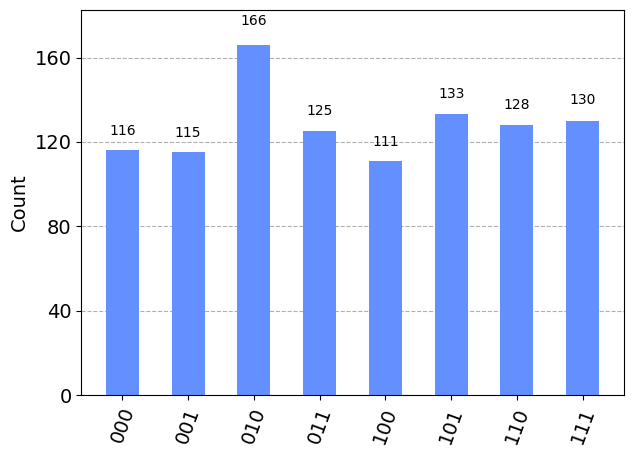

In [643]:

# run the circuit
qasm_simulator = Aer.get_backend("qasm_simulator")
transpiled_circuit = transpile(circuit, qasm_simulator)
qobj = assemble(transpiled_circuit)
result = qasm_simulator.run(qobj).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)